In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 한글 폰트
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 그래프 마이너스 폰트 깨지는 문제 대처
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

import mglearn

평가지표    
- 모델을 선택하고, 매개변수를 튜닝할 때 올바른 지표를 선택하는 것이 중요
- 평가 지표를 선택할 때 머신러닝 애플리케이션의 최종 목표(고차원적인 목표)를 기억해야 함
    - 원래 비즈니스 목적에 가장 가까운 지표를 찾아야 함
    - 평가의 결과는 하나의 숫자가 아닐 수 있지만, 선택한 모델의 예상 비즈니스 임팩트를 나타내야함
        - 비즈니스 임팩트: 어떤 머신러닝 애플리케이션에서 특정 알고리즘을 선택하여 나타난 결과
        - ex. 어떤 알고리즘을 적용하면 고객 수는 10% 늘지만, 고객당 매출은 15% 줄어들 수 있음

# 이진 분류의 평가 지표
- 이진 분류에는 양성 클래스와 음성 클래스가 있으며, 양성 클래스가 우리의 관심 클래스임

## Error의 종류
- 정확도만으로 예측 성능을 측정하기에는 부족할 때가 종종 있음
- 어떤 애플리케이션에서든 이런 분류 오류가 실제 현실에서 어떤 결과를 초래하는 지 살펴봐야 함

두 종류의 에러    (F붙은건 앞(P/N)에 반대인 것으로 생각하면 쉬움)
암 진단 예시 - 양성(암), 음성(건강)
1. 거짓 양성(False Positive, FP) 
    - 잘못된 양성 예측 (통계학에서는 type 1 error)
    - 건강한 사람을 양성으로 분류하면 추가 검사를 받게함 -> 환자에게 비용 손실과 불편함을 가져다줌

2. **거짓 음성(False Negetive, FN)**
    - 잘못된 음성 예측 오류 (통계학에서는 type 2 error)
    - 암에 걸린 사람을 음성으로 분류하여, 제대로 된 검사나 치료를 받지 못하게 함 -> 건강에 심각한 위협을 가하며, 치명적일 수 있음

=> 암 진단 예시에서는 **거짓 음성**을 최대한 피야하며, 거짓 양성은 비교적 중요도가 낮음

- 이 예시는 극단적인 예이지만, 일반적으로도 거짓음성/거짓양성의 중요도가 차이가 나는 경우가 많음
- 상업적 애플리케이션에서는 두 오류를 비용으로 환산하여, 예측 오류로 인한 금전적 손해를 측정한 값을 정확도 대신 사용하기도 함

## 불균형 데이터셋
- 두 종류의 에러(거짓 양성/거짓 음성)는 한 클래스가 다른 것보다 훨씬 많은 **불균형 데이터셋일 때 더 중요함**
    - 현실에서 불균형 데이터가 훨씬 많으며, 관심 대상인 이벤트의 빈도가 그렇지 않은 이벤트와 비슷한 경우는 드뭄
    - ex. 광고 노출 시 클릭 예측 -> 100개 data 중 '클릭 X' 99개, '클릭' 1개 -> 모두 클릭 아님으로 예측해도 정확도가 99%가 됨;

In [2]:
# digits data set - 숫자 9를 다른 숫자(0~8)와 구분해서 9:1의 불균현 데이터셋 생성
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
y = digits.target == 9    # y값 True/False

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

In [3]:
# DummyClassifier - 실제 모델과 비교하기 위해 간단한 규칙을 지원하는 모델
# strategy 옵션 - most_frequent(가장 많은 레이블 예측)으로 설정
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print('예측된 유니크 레이블: ', np.unique(pred_most_frequent))
print('테스트 점수: {:.2f}'.format(dummy_majority.score(X_test, y_test)))

예측된 유니크 레이블:  [False]
테스트 점수: 0.90


- 거의 아무것도 학습하지 않고 90% 정확도를 얻음

In [4]:
# 실제 분류기 사용
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print('테스트 점수: {:.2f}'.format(tree.score(X_test, y_test)))

테스트 점수: 0.92


- 정확도로 보면 결정트리가 더미 분류기보다 조금 나을 뿐
    - 이는 결정트리를 잘못 사용했거나, 이 문제에서는 정확도가 높은 측정 방법이 아님을 말해줌

In [5]:
# 로지스틱 회귀, 더미 분류기 비교
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print('dummy 점수: {:.2f}'.format(dummy.score(X_test, y_test)))

logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print('logreg 점수: {:.2f}'.format(logreg.score(X_test, y_test)))

dummy 점수: 0.82
logreg 점수: 0.98


C:\Users\qkrwl\anaconda3\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
C:\Users\qkrwl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- 정확도만으로는 결과가 실제로 유용한 것인지 판단하기 매우 어려움
    - 불균형 데이터셋에서 예측 성능을 정량화하는 데 정확도는 적절한 측정 방법이 아니기 때문
- 빈도나 무작위 기반 예측보다 얼마나 더 나은지 알려주는 평가 지표가 필요함
     - 모델을 평가하는 지표라면 이런 비상식적인 예측은 피할 수 있어야함!

## 오차 행렬(confusion matrix)
- 오차 행렬은 이진 분류 평가 결과를 나타낼 때 가장 널리 사용하는 방법 중 하나
- confusion_matrix 함수 사용
    - 출력은 2 X 2 배열
    - 행은 정답 클래스에 해당
    - 열은 예측 클래스에 해당
    - confusion_matrix(y_test, pred)
- 오차 행렬의 대각 행렬 [i,i]은 정확히 분류된 경우
    - 진짜 양성(True Positive, TP): 양성 클래스로 올바르게 분류한 샘플
    - 진짜 음성(True Negetive, TN): 음성 클래스로 정확하게 분류한 샘플
- 다른 항목은 한 클래스의 샘플들이 다른 클래스로 잘못 분류된 경우


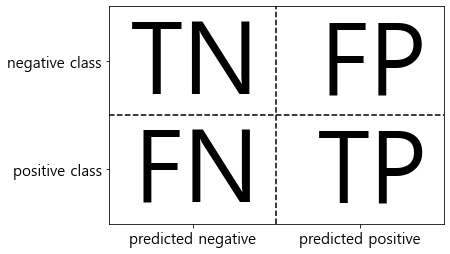

In [6]:
mglearn.plots.plot_binary_confusion_matrix()

In [7]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print('오차 행렬:\n', confusion)

오차 행렬:
 [[402   1]
 [  6  41]]


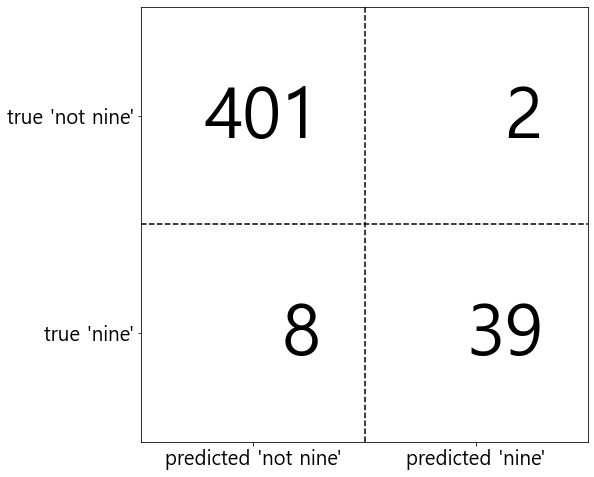

In [8]:
mglearn.plots.plot_confusion_matrix_illustration()

In [9]:
# 오차 행렬을 사용하여, 앞서 만든 모델들 비교
print('빈도 기반 더미 모델:')
print(confusion_matrix(y_test, pred_most_frequent))
print('\n무작위 더미 모델:')
print(confusion_matrix(y_test, pred_dummy))
print('\n결정 트리:')
print(confusion_matrix(y_test, pred_tree))
print('\n로지스틱 회귀:')
print(confusion_matrix(y_test, pred_logreg))

빈도 기반 더미 모델:
[[403   0]
 [ 47   0]]

무작위 더미 모델:
[[355  48]
 [ 44   3]]

결정 트리:
[[390  13]
 [ 24  23]]

로지스틱 회귀:
[[402   1]
 [  6  41]]


- pred_most_frequent, pred_dummy는 잘못된 것이 확실함
- 결정 트리의 예측은 더미 분류기보다 정상으로 보이지만, 정확도는 거의 비슷
- 로지스틱 회귀는 모든 면에서 결정 트리 예측보다 나음
    - 진짜 양성과 진짜 거짓이 더 많고, 거짓 양성과 거짓 음성은 적음

- **오차 행열의 모든 면을 살펴보면 많은 정보를 얻을 수 있음**
- 하지만, **매우 수동적이며 정성적인 방법**
-> 오차 행렬 정보를 **요약**할 수 있는 여러 방법 알아보자!

## 오차 행렬 정보/결과 요약하는 방법
1. 정확도
    - 정확히 예측한 수(TP, TN)를 전체 샘플 수(TP,TN,FP,FN)로 나눈 것
2. 정밀도 - precision (양성 예측도, PPV)
    - **양성으로 예측된 것(TP, FP)** 중 얼마나 많은 **샘플이 진짜 양성(TP)**인지 측정
    - **거짓 양성(FP)의 수를 줄이는 것이 목표**일 때 성능 지표로 사용됨
        - ex. 임상시험 비쌈. 단 한 번의 실험으로 신약의 효과 검증하기를 원함 -> 모델이 거짓 양성(FP, 효과가 없는데 효과가 있다고 나타난 경우)을 많이 만들지 않는 것이 중요
3. 재현율 - recall (민감도, 적중률, 진짜 양성 비율 TPR)
    - **전체 양성 샘플(TP, FN <- 진짜 양성 샘플들)** 중에서 얼마나 많은 샘플이 **양성 클리스(TP)로 분류/예측 되는지** 측정
    - **모든 양성 샘플을 식별해야 할 때** 성능 지표로 사용 <- **거짓 음성(FN)을 피하는 게 중요할 때** 
        - ex. 암 진단에서, 건강한 사람이 일부 포함되더라도, 암에 걸린 사람을 빠짐없이 찾는 것이 중요     
            
=> 하지만, 재현율 최적화와 정밀도 최적화는 **상충함**   
=> **둘 중 하나 만으로는 전체 그림을 볼 수 없음**  
4. f1-score
    - 정밀도와 재현율의 조화 평균인 f-점수(f1-score)는 **이 둘을 하나로 요약**해줌
    - 정밀도와 재현율을 **같이 고려**하므로, **불균형한 이진 분류 데이터셋에서는 정확도보다 더 나은 지표가 될 수 있음**
    - f1-score를 사용해 평가하면, **예측 성능이 다시 하나의 숫자로 요약됨**
    - 하지만, f1-score는 정확도보다 이해하거나 설명하기 어렵다는 게 단점

In [10]:
# digits - 9가 양성클래스로 가정한 set
from sklearn.metrics import f1_score

print('빈도 기반 더미 모델의 f1 score: {:.2f}'.format(f1_score(y_test, pred_most_frequent)))
print('무작위 더미 모델의 f1 score: {:.2f}'.format(f1_score(y_test, pred_dummy)))
print('트리 모델의 f1 score: {:.2f}'.format(f1_score(y_test, pred_tree)))
print('로지스틱 회귀 모델의 f1 score: {:.2f}'.format(f1_score(y_test, pred_logreg)))

빈도 기반 더미 모델의 f1 score: 0.00
무작위 더미 모델의 f1 score: 0.06
트리 모델의 f1 score: 0.55
로지스틱 회귀 모델의 f1 score: 0.92


- 무작위 더미 분류기와 트리 분류기 사이에서 정확도에는 없던 뚜렷한 차이를 볼 수 있음
- f1-score를 사용해 평가하면, 예측 성능이 다시 하나의 숫자로 요약됨

**classification_report 함수** - 분류 리포트
- 정밀도, 재현율, f1-score 3개 모두를 한 번에 계산해서 깔끔하게 출력해줌
- class마다 한 줄씩 출력을 만들고, **각 class가 양성일 때의** 정밀도, 재현율, f1-score를 리포드함
- support는 각 클래스에 대한 지지도로, 단순히 이 class에 있는 진짜 샘플의 수
- 마지막 3 줄은 정밀도, 재현율, f1-score의 평균을 보여줌
    - macro avg는 단순히 class별 점수의 평균을 계산한 것
    - weighted avg는 class의 샘플 수로 가중 평균한 것

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_most_frequent, target_names=['9 아님','9']))

              precision    recall  f1-score   support

        9 아님       0.90      1.00      0.94       403
           9       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



C:\Users\qkrwl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- 만약 양성 클래스를 '9 아님'으로 바꾼다면, f1-socre가 0.94
- 모든 샘플을 '9 아님'으로 분류하기 때문에, '9 아님' class의 재현율이 1인 것

In [12]:
print(classification_report(y_test, pred_dummy, target_names=['9 아님','9']))

              precision    recall  f1-score   support

        9 아님       0.89      0.88      0.89       403
           9       0.06      0.06      0.06        47

    accuracy                           0.80       450
   macro avg       0.47      0.47      0.47       450
weighted avg       0.80      0.80      0.80       450



In [13]:
print(classification_report(y_test, pred_tree, target_names=['9 아님','9']))

              precision    recall  f1-score   support

        9 아님       0.94      0.97      0.95       403
           9       0.64      0.49      0.55        47

    accuracy                           0.92       450
   macro avg       0.79      0.73      0.75       450
weighted avg       0.91      0.92      0.91       450



In [14]:
print(classification_report(y_test, pred_logreg, target_names=['9 아님','9']))

              precision    recall  f1-score   support

        9 아님       0.99      1.00      0.99       403
           9       0.98      0.87      0.92        47

    accuracy                           0.98       450
   macro avg       0.98      0.93      0.96       450
weighted avg       0.98      0.98      0.98       450



- **어떤 class를 양성 class로 선택하느냐가 평가 지표에 큰 영향을 끼침**
  - 더미 모델과 로지스틱 회귀 모델의 양성 class가 '9아님'일 경우 f1-socre가 0.89, 0.99라서 둘다 성능 좋음
  - 하지만, 모든 숫자를 함께보면, 정확한 판단을 내릴 수 있어 로지시틱 회귀 모델의 우수성을 알 수 있음

## 불확실성 고려 -  임계값 조정하기
- 오차 행렬과 분류 리포트가 예측 결과를 자세히 분석할 수 있도록 도와줌
- 하지만, 예측값은 모델에 담긴 많은 정보가 이미 손실된 상태
    - 대부분의 분류기는 예측의 확신을 가늠하기 위한 decision_function or predict_proba 메서드 제공
    - 예측을 만들어 내는 것은 출력의 임계값을 검증한는 것
        - 이진 탐색에서 decision_function은 0, predict_proba는 0.5를 임계값으로 사용함
- 결정 함수의 임계값을 바꾸면, 더 나은 결과를 쉽게 얻을 수 있음(재현율보다 정밀도가 중요 or 그 반대의 경우 or 심한 불균형 데이터일 경우)
    - decision_funcion
        - 기본적으로 0보다 크면 class 1로 분류 (범위가 고정되지 않은, 임의의 범위를 가짐)
        - class 1의 재현율을 높일 때(더 많은 포인트가 class 1로 분류되려면), 임계값을 낮추면 됨
    - predict_proba
        - 기본적으로 양성 클래스 확률이 0.5이상일 때 양성으로 분류 (출력이 0 ~ 1 사이로 고정됨)
        - 임계값을 높이면, 양성 클래스로 분류할 때 더 큰 확신이 있어야함(음성 클래스는 확신이 덜 필요)
- 임계값을 선택할 때 test set을 사용하지 않도록 주의!
    - 대신, validation set or cross-validation(교차검증) 사용하자!

In [15]:
# 음성 class 400개, 양성 class 50개 - 불균형 data set

from sklearn.datasets import make_blobs
from sklearn.svm import SVC

X, y = make_blobs(n_samples=(400,50), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)

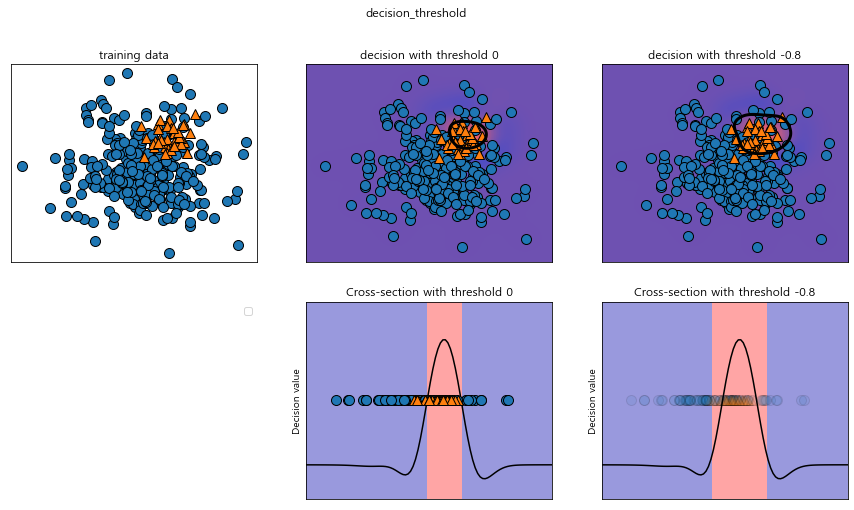

In [16]:
# svm 결정 함수 값을 히트맵으로 나타내기
mglearn.plots.plot_decision_threshold()

- 결정 함수의 히트맵과 임계값 변화에 따른 영향
- 검은 원은 decision_function이 정확히 0일 때의 임계점을 나타냄 - 원 안: 양성 class, 원 밖: 음성 class로 분류됨

In [17]:
# classification_repor
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

    accuracy                           0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



- class 1에 대해 상당히 작은 정밀도를 얻었으며, 재현율은 절반 정도임
- **class 0의 샘플이 매우 많으므로, 분류기는 소수인 class 1보다 class 0에 초점을 맞추고 있음**

- class 1의 재현율을 높이는 게 중요하다고 가정 -> 거짓 양성(FP)이 늘어나더라도, 진짜 양성(TP)을 늘려야함
- 임계값을 바꿔 class 1의 재현율을 높이도록 예측 조정
    - 기본적으로 decision_function의 값이 0보다 큰 포인트는 class 1로 분류됨
    - 더 많은 포인트가 class 1로 분류되려면 임계값을 낮춰야함

In [18]:
svc.decision_function(X_test)

array([-0.99973208, -1.00148617, -1.1386043 , -0.98505482, -1.01044247,
       -1.00027441, -1.00609413,  0.88395198, -1.00467053, -1.00283866,
       -1.00097712,  1.07030762, -1.02076344, -0.40435353, -0.48739733,
       -1.00121046, -1.09560781, -1.44572917, -0.99908802, -1.00070245,
       -0.44364565, -1.01170286, -0.99918954, -1.0861769 , -1.33291363,
       -1.00320657, -0.99076097, -1.09564958,  0.63212214, -0.99238394,
       -1.47090403,  0.19153373,  0.74430046, -1.0084656 , -1.15104651,
       -1.02852903, -1.00840776, -1.23180696, -1.0031964 , -1.00023926,
       -1.0013854 , -1.00003771, -1.10114776, -0.98779744, -1.05818617,
       -1.00105363,  0.5230006 ,  0.97789353, -0.99559099,  0.52008479,
       -1.25711078, -1.08267667, -0.99828696, -1.00385465,  0.08620484,
       -0.99871026, -1.06221884, -1.02415268, -1.08797969, -1.06010122,
        0.36988055, -1.05630237, -0.99981001, -0.24173165, -1.02857919,
       -1.00058106, -0.99968788, -1.00115386, -0.99882791,  1.25

In [19]:
# -0.8로 임계값 낮추기 
y_pred_lower_threshold = svc.decision_function(X_test) > -.8

In [20]:
y_pred_lower_threshold

array([False, False, False, False, False, False, False,  True, False,
       False, False,  True, False,  True,  True, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True, False, False, False, False,
        True, False, False, False, False, False,  True, False, False,
        True, False, False, False, False, False,  True, False, False,
       False,  True,  True, False, False, False,  True, False, False,
        True, False, False,  True, False,  True, False,  True, False,
       False,  True, False, False, False,  True, False, False, False,
        True, False, False, False,  True, False, False,  True, False,
       False, False,  True, False, False])

In [21]:
print(classification_report(y_test, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

    accuracy                           0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



- class 1의 재현율은 높아지고, 정밀도는 낮아짐
- 더 넓은 영역이 class 1로 분류됨

## 정밀도-재현율 곡선
- 모델의 분류 작업을 결정하는 **임계값을 바꾸는 것**은 해당 분류기의 **정밀도와 재현율의 상충 관계를 조정하는 일**
- 어떤 목표가 선택되면(어떤 class에 대한 특정 재현율 or 정밀도의 값) 적절한 임계값을 지정하는 것은 쉬움 <- 운영 포인트 지정
    - ex. 90% 이상의 재현율
- 하지만, 어려운 부분은 이 임계값을 유지하면서 적절한 정밀도(or 재현율)를 내는 모델을 만드는 일
- 새로운 모델을 만들 때는 운영 포인트가 명확하지 않은 경우가 많음
    - 이런 경우 문제를 더 잘 이해하기 위해 모든 임계값을 조사해보거나, 한번에 정밀도나 재현율의 모든 장단점 살펴 보는 것이 좋음
    - 이를 위해 **정밀도-재현율 곡선(precision-recall curve)**을 사용함 <- sklearn.metrics 모듈 precision_recall_curve 함수
        - target label과 decision_function or predict_proba 메서드로 계산한 예측 불확실성 이용함
        - 가능한 모든 임계값(결정 함수에 나타난 모든 값)에 대해 정밀도와 재현율의 값을 정렬된 list로 반환함
        -> 곡선 그래프 그릴 수 있음

In [22]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))   # thresholds: 임계값

In [23]:
thresholds

array([-0.7512563 , -0.58749402, -0.48739733, -0.44364565, -0.40435353,
       -0.28965335, -0.24173165, -0.19257469, -0.17852475, -0.16644845,
       -0.1601932 ,  0.08620484,  0.14630375,  0.19153373,  0.36988055,
        0.52008479,  0.5230006 ,  0.53195462,  0.63212214,  0.74430046,
        0.87212596,  0.88002558,  0.88395198,  0.97789353,  1.00010384,
        1.07030762,  1.08436417,  1.25059991])

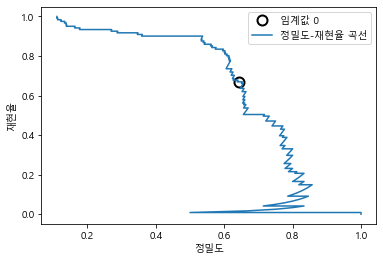

In [24]:
# 부드러운 곡선을 위해 데이터 포인트 수 늘리기
X,y = make_blobs(n_samples=(4000, 500), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 모델 학습
svc = SVC(gamma=.05).fit(X_train, y_train)

# 정밀도-재현율 계산
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

# 0에 가장 가까운 임계값 찾기
close_zero = np.argmin(np.abs(thresholds))   # decision_function(X_test)의 결과에 0이 포함되지 않을 수 있어, 가장 작은 거 구함
# 임계값 0 포인트
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label='임계값 0', fillstyle='none', c='k', mew=2)

plt.plot(precision, recall, label='정밀도-재현율 곡선')
plt.xlabel('정밀도')
plt.ylabel('재현율')
plt.legend(loc='best')

- 곡선의 각 포인트는 decision_function의 가능한 모든 임계값에 대응함
    - ex. 정밀도가 약 0.75일 때의 재현율은 0.4
- 검은 원은 decision_function의 기본 임계값인 0 지점을 나타냄
    - 이 지점은 predict 메서드를 호출할 때 사용되는 임계값(기본값)
- 곡선이 오른쪽 위로 갈수록 더 좋은 분류기 (정밀도와 재현율이 모두 높게 유지되는 곳)
    - 임계값이 커지면서 곡선은 정밀도가 높아지는 쪽으로 이동하지만, 재현율은 낮아짐
    - 임계값을 높일수록 양성으로 분류된 포인트 대부분이 진짜 양성(TP)이 되어 정밀도가 매우 높아지지만, 재현율은 낮아짐
        - 임계값이 높으면 양성 샘플이 TP로 분류되지 못하고 FN이 되기 때문에
- 분류기가 다르면 곡선의 다른 부분에서 장점이 생김

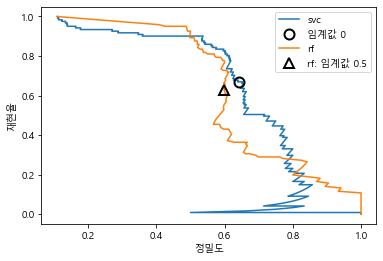

In [25]:
# svm vs 랜덤포레스트
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)
# 정밀도-재현율 계산, RandomForestClassifier - predict_proba
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf.predict_proba(X_test)[:,1])

# svc
plt.plot(precision, recall, label='svc')
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label='임계값 0', fillstyle='none', c='k', mew=2)

# 랜포
plt.plot(precision_rf, recall_rf, label='rf')
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))   # 기본 임계값 0.5와 가장 비슷한 임계점 찾기
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k', markersize=10, label='rf: 임계값 0.5', fillstyle='none', mew=2)

plt.xlabel('정밀도')
plt.ylabel('재현율')
plt.legend(loc='best')

- 극단적인 부분, 즉 재현율 or 정밀도가 매우 높을 때는 랜덤 포레스트가 더 나음
- 가운데 근처(정밀도=0.7정도)에서는 svm이 더 좋음, 즉 오른쪽 위 코너에 더 가까움
- 만약 f1-score만으로 전체 성능을 비교한다면 이런 세세한 부분을 놓칠 수 있음
    - f1-score는 기본 임계값에 대한 점수(정밀도-재현율 곡선의 한 지점)

In [26]:
print('랜덤 포레스트의 f1_score: {:.3f}'.format(f1_score(y_test, rf.predict(X_test))))
print('svc의 f1_score: {:.3f}'.format(f1_score(y_test, svc.predict(X_test))))

랜덤 포레스트의 f1_score: 0.610
svc의 f1_score: 0.656


- 두 정밀도-재현율 곡선을 비교하면 많은 통찰을 얻을 수 있지만, 수작업임
- 전체 곡선에 담긴 정보 요약 방법(모든 임계값에 대해 평균) - **평균 정밀도(average precision)**
    - 정밀도-재현율 곡선의 아랫부분 면적을 계산
    - average_precision_score 함수가 평균 정밀도를 계산해줌
    - 평균 정밀도는 0 ~ 1 사이 범위값 반환함
        - 0: 가장 나쁨
        - 1: 가장 좋음

In [27]:
from sklearn.metrics import average_precision_score

ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:,1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))

print('랜덤 포레스트의 평균 정밀도: {:.3f}'.format(ap_rf))
print('svc의 평균 정밀도: {:.3f}'.format(ap_svc))

랜덤 포레스트의 평균 정밀도: 0.660
svc의 평균 정밀도: 0.666


- 모든 임계값에 대해 평균을 내보면, 랜덤 포래스트가 조금 낮지만, svc와 거의 같은 성능임
- f1_score 결과와 좀 다름

## ROC 곡선과 AUC 
- ROC 곡선 (receiver operating characteristics) - roc_curve 함수 사용
    - 'TPR(재현율)-FPR 곡선'으로 이해하는 것이 좋음
    - 분류기의 모든 임계값을 고려하며, (정밀도와 재현율 대신) 진짜 양성 비율(TPR, 재현율)과 거짓 양성 비율(FPR)을 나타냄
    - FPR = FP/(FP+TN)
    - ROC 곡선은 왼쪽 위에 가까울 수록 이상적임
        - 거짓 양성 비율(FPR)이 낮게 유지되면서, 재현율(진짜 양성 비율, TPR)이 높은 분류기가 좋은 것
    - 임계값 고르기 위해서는 test set이 아닌, 별도의 검증 set을 활용해야!!
    
- AUC(area under the curve, curve = ROC) - roc_auc_score 함수
    - 곡선 아래의 면적값 하나로 ROC 곡선 요약하는 것 (이 면적을 AUC 라고 함)
        - 항상 0(최악) ~ 1(최선) 사이의 값을 가짐
    - 데이터에 담긴 클래스가 아무리 불균형하더라도 무작위로 예측한 AUC 값은 0.5가됨
        - 클래스 불균현이 FPR과 TPR 계산에 영향을 주지 않음 (오차 행렬에서 각각 다른 행을 이용하여 만들기때문에)
        - 무작위로 분류하면 클래스별 양성과 음성의 비율이 비슷해서 FPR과 TPR 값이 거의 같아져, ROC곡선은 y=x에 가까워짐 -> AUC 면적은 0.5가됨
    - **불균형한 데이터셋에서는 정확도보다 AUC가 훨씬 좋은 지표임!**
    - AUC는 분류기에서 무작위로 선택한 양성 클래스 포인트의 점수가 음성 클래스 포인트의 점수보다 높은 확률과 같음
        - AUC가 1일 때는 모든 양성 포인트의 점수가 모든 음성 포인트의 점수보다 높음
        - 양성 포인트가 음성 클래스로 분류될 가능성이 없기 때문에 FN이 0이되고, TPR(재현율)은 항상 1이됨

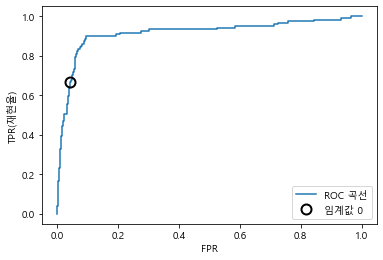

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label='ROC 곡선')
plt.xlabel('FPR')
plt.ylabel('TPR(재현율)')
# 0 근처의 임계값을 찾음
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='임계값 0', fillstyle='none', c='k', mew=2)
plt.legend(loc=4)

- 기본 임계값 0의 지점과 비교했을 때, FPR을 조금 늘리면 재현율을 아주 크게 높일 수 있음(0.9부근)

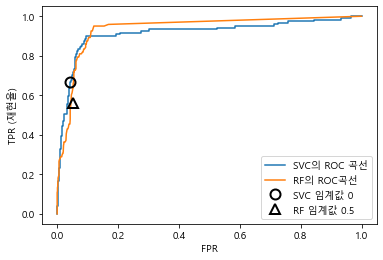

In [32]:
# 랜덤 포레스트와 SVM의 ROC 곡선 비교
from sklearn.metrics import roc_curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label='SVC의 ROC 곡선')
plt.plot(fpr_rf, tpr_rf, label='RF의 ROC곡선')

plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='SVC 임계값 0', fillstyle='none', c='k', mew=2)

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10, label='RF 임계값 0.5', fillstyle='none', c='k', mew=2)

plt.xlabel('FPR')
plt.ylabel('TPR (재현율)')
plt.legend(loc=4)

- fpr이 약 0.1 이상일때 랜덤 포레스트의 성능이 좀더 나은 것 같음

In [33]:
# AUC
from sklearn.metrics import roc_auc_score

rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))

print('랜덤 포레스트의 AUC: {:.3f}'.format(rf_auc))
print('SVC의 AUC: {:.3f}'.format(svc_auc))

랜덤 포레스트의 AUC: 0.937
SVC의 AUC: 0.916


- AUC 점수로 랜덤 포레스트와 SVM을 비교하니, 랜덤 포레스트의 성능이 SVM보다 조금 너 나음

gamma = 1.00, 정확도 = 0.90, AUC = 0.50
gamma = 0.10, 정확도 = 0.90, AUC = 0.96
gamma = 0.01, 정확도 = 0.90, AUC = 1.00


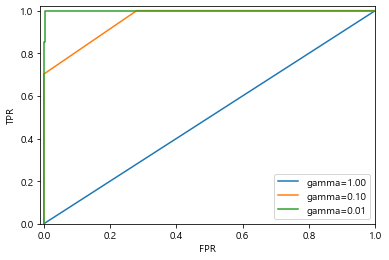

In [40]:
# 각기 다른 gamma -> SVM 학습
y = digits.target == 9
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

plt.figure()
for gamma in [1, 0.1, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test, svc.decision_function(X_test))
    print('gamma = {:.2f}, 정확도 = {:.2f}, AUC = {:.2f}'.format(gamma, accuracy, auc))
    plt.plot(fpr, tpr, label='gamma={:.2f}'.format(gamma))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc='best')

- gamma가 변해도 정확도 점수는 같으나, auc는 차이다 뚜렸하게 나타남
- gamma = 1.0에서 AUC는 무작위로 선택한 수준(0.5)
- gamma가 0.01일 때 곡선이 왼쪽 위에 가까이 있어, 가장 성능이 좋음
    - 적절한 임계값에서 이 모델은 데이터를 거의 완벽하게 분류할 수 있음!
- 불균형한 데이터셋에서 모델을 평가할 때는 AUC를 사용해야함
- 하지만, AUC값이 기본 임계값과는 상관 없으므고, AUC가 높은 모델에서 좋은 분류결과를 얻으려면 **결정 임계값 조정해야함**

# 다중 분류의 평가 지표
- 다중 분류를 위한 지표는 기본적으로 모두 이진 분류 평가 지표에서 유도되었음
    - 다만, 모든 클래스에 대해 평균을 낸 것
- 앞 절의 이진 분류에서 사용한 오차 행렬과 분류 리포드 등을 일반적으로 사용
- 정확도는 클래스가 불균형할 때 좋은 평가 방법이되지 못함

In [41]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)

lr = LogisticRegression(solver='liblinear', multi_class='ovr').fit(X_train, y_train)
pred = lr.predict(X_test)
print('정확도: {:.3f}'.format(accuracy_score(y_test, pred)))
print('오차 행렬:\n', confusion_matrix(y_test, pred))

정확도: 0.953
오차 행렬:
 [[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


- 모델의 정확도는 95.3%로 꽤 좋은 성능을 냄
- 오차 행렬에서는 더 자세한 내용이 담겨 있음

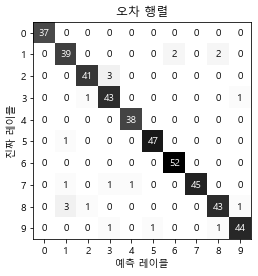

In [44]:
# 더 깔끔하게 시각화
score_image = mglearn.tools.heatmap(confusion_matrix(y_test, pred), xlabel='예측 레이블', ylabel='진짜 레이블', 
                                    xticklabels=digits.target_names, yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt='%d')
plt.title('오차 행렬')
plt.gca().invert_yaxis()

- 숫자 0은 모두 클래스 0으로 분류됨 (거짓 음성 FN이 없음)
- 4,6은 오차 없이 정확하게 분류했지만, 다른 클래스가 잘못 분류한 것이 몇개 있음(FP)
- 그 외 숫자는 잘못 분류한 것이 몇개 있음

In [46]:
# 정밀도, 재현율, f1-score 계산
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.91      0.90        43
           2       0.95      0.93      0.94        44
           3       0.90      0.96      0.92        45
           4       0.97      1.00      0.99        38
           5       0.98      0.98      0.98        48
           6       0.96      1.00      0.98        52
           7       1.00      0.94      0.97        48
           8       0.93      0.90      0.91        48
           9       0.96      0.94      0.95        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



- 0은 오차, 거짓음성이 없으므로, 정밀도와 재현율 모두 1로 완벽함
- 7은 다른 클래스가 7로 잘못 분류한 것이 없어, 정밀도(precision)가 1임
- 4,6은 거짓 음성(FN)이 없어서 재현율(recall)이 1임
- 이 모델은 1,3,8을 분류하는 데 어려움을 겪고 있음

## 다중 분류 ver.의 f1-score
- 다중 클래스용 f1-score는 한 클래스를 양성 클래스로 두고, 나머지 클래스들을 음성 클래스로 간주하여, 클래스마다 f1-score를 계산
- 클래스별 f1-score를 평균내는 3개지 전략(average 매개변수로 설정하며, 기본값은 이진분류에 해당하는 'binary')
    1. 'macro' 평균
        - 클래스 크기에 상관없이 모든 클래스를 같은 비중으로 다룸
        - 각 클래스를 동일한 비중으로 고려한다면 이 평균 추천
    2. 'weighted' 평균
        - 클래스별 샘플 수로 가중치를 두어 f1-score의 평균을 계산
    3. 'micro' 평균
        - 모든 클래스의 거짓 양성(FP), 거짓 음성(FN), 진짜 양성(TP)의 총 수를 헤아린 다음, 정밀도, 재현율, f1-score를 이 수치로 계산
        - 각 샘플을 똑같이 간주한다면 이 평균 추천

In [47]:
print('micro 평균 f1-score: {:.3f}'.format(f1_score(y_test, pred, average='micro')))
print('macro 평균 f1-score: {:.3f}'.format(f1_score(y_test, pred, average='macro')))

micro 평균 f1-score: 0.953
macro 평균 f1-score: 0.954


# 회귀의 평가 지표
- 회귀 평가는 분류에서와 비슷하게 할 수 있으나, 대부분은 R^2만으로 충분함
- 가끔 평균제곱에러(MSE), 평균제곱은오차(RMSE), 평균절댓값에러(MAE)를 사용

# GridSearchCV나 cross_val_score에서 다른 평가 지표 사용하기
- GridSearchCV나 cross_val_score를 사용하여 모델을 선택할 때, AUC 같은 평가 지표를 사용하고 싶은 경우가 많이 있음
- scoring 매개변수를 통해 쉽게 구현 가능
    - ex. 기본값(정확도)에서 평균 정밀도로 지표 변경: scoring 매개변수에 average_precision 지정
    - GridSearchCV, cross_validate 함수는 한번에 여러 측정 지표 계산 가능 (list로 묶어서 넘겨주면 됨)
    - cross_val_score는 한번에 하나의 측정 지표만 계산 가능
    - scoring 옵션 종류
        - 분류: accuracy(기본값), roc_acu, average_precision, f1_macro, f1_micro, f1_weighted, ...
        - 회귀: r2, mean_squared_error, mean_absolute_error, ...

## cross_val_score

In [50]:
from sklearn.model_selection import cross_val_score

# 분류의 기본 평가 지표: 정확도
print('기본 평가 지표(정확도):', cross_val_score(SVC(), digits.data, digits.target == 9, cv=5))   # scoring='accuracy'

# AUC
roc_auc = cross_val_score(SVC(), digits.data, digits.target == 9, scoring='roc_auc', cv=5)
print('AUC 지표: ', roc_auc)

# 평균 정밀도 지표
ap = cross_val_score(SVC(), digits.data, digits.target == 9, scoring='average_precision', cv=5)
print('평균 정밀도 지표: ', ap)

기본 평가 지표(정확도): [0.975      0.99166667 1.         0.99442897 0.98050139]
AUC 지표:  [0.99717078 0.99854252 1.         0.999828   0.98400413]
평균 정밀도 지표:  [0.97562403 0.9886322  1.         0.99853801 0.95015534]


In [51]:
ttest = cross_val_score(SVC(), digits.data, digits.target == 9, scoring=['average_precision', 'roc_auc'], cv=5)

ValueError: For evaluating multiple scores, use sklearn.model_selection.cross_validate instead. ['average_precision', 'roc_auc'] was passed.

## cross_validate

In [54]:
from sklearn.model_selection import cross_validate

# cross_validate 함수에 여러 측정 지표 한번에 계산
res = cross_validate(SVC(), digits.data, digits.target == 9, scoring=['accuracy','roc_auc','recall_macro'], return_train_score=True, cv=5)
res

{'fit_time': array([0.05248785, 0.04690504, 0.03124237, 0.04682779, 0.04686427]),
 'score_time': array([0.02293706, 0.01562071, 0.01562405, 0.01566219, 0.01562786]),
 'test_accuracy': array([0.975     , 0.99166667, 1.        , 0.99442897, 0.98050139]),
 'train_accuracy': array([0.99443285, 0.99582463, 0.99513213, 0.99582754, 0.99652295]),
 'test_roc_auc': array([0.99717078, 0.99854252, 1.        , 0.999828  , 0.98400413]),
 'train_roc_auc': array([0.99867878, 0.99914067, 0.99897497, 0.9988247 , 0.99991413]),
 'test_recall_macro': array([0.88734568, 0.95833333, 1.        , 0.97222222, 0.90277778]),
 'train_recall_macro': array([0.97222222, 0.98225219, 0.97878027, 0.98225249, 0.98572471])}

In [55]:
# df로 보기
pd.DataFrame(res)

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_recall_macro,train_recall_macro
0,0.052488,0.022937,0.975000,0.994433,0.997171,0.998679,0.887346,0.972222
1,0.046905,0.015621,0.991667,0.995825,0.998543,0.999141,0.958333,0.982252
2,0.031242,0.015624,1.000000,0.995132,1.000000,0.998975,1.000000,0.978780
3,0.046828,0.015662,0.994429,0.995828,0.999828,0.998825,0.972222,0.982252
4,0.046864,0.015628,0.980501,0.996523,0.984004,0.999914,0.902778,0.985725


## GridSearchCV
- GridSearchCV에서 **최적의 매개변수를 선택하기 위한 평가지표** 변경 가능

In [60]:
from sklearn.model_selection import GridSearchCV

# 기본값인 정확도 사용
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target == 9, random_state=0)

# 일부로 적절하지 않은 grid 생성
param_grid = {'gamma':[0.0001, 0.01, 0.1, 1, 10]}

# 기본 정확도 측정 지표 사용
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=3)
grid.fit(X_train, y_train)

print('정확도 지표를 사용한 그리드 서치')
print('최적의 파라미터:', grid.best_params_)
print('최상의 교차 검증 점수(정확도): {:.3f}'.format(grid.best_score_))
print('테스트 세트 평균 정밀도: {:.3f}'.format(average_precision_score(y_test, grid.decision_function(X_test))))
print('테스트 세트 정확도: {:.3f}'.format(grid.score(X_test, y_test)))

정확도 지표를 사용한 그리드 서치
최적의 파라미터: {'gamma': 0.0001}
최상의 교차 검증 점수(정확도): 0.972
테스트 세트 평균 정밀도: 0.966
테스트 세트 정확도: 0.973


In [61]:
# 평균 정밀도 지표 사용
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring='average_precision', cv=3)
grid.fit(X_train, y_train)

print('평균 정밀도 지표를 사용한 그리드 서치')
print('최적의 파라미터:', grid.best_params_)
print('최상의 교차 검증 점수(평균 정밀도): {:.3f}'.format(grid.best_score_))
print('테스트 세트 평균 정밀도: {:.3f}'.format(average_precision_score(y_test, grid.decision_function(X_test))))
print('테스트 세트 정확도: {:.3f}'.format(grid.score(X_test, y_test)))

평균 정밀도 지표를 사용한 그리드 서치
최적의 파라미터: {'gamma': 0.01}
최상의 교차 검증 점수(평균 정밀도): 0.985
테스트 세트 평균 정밀도: 0.996
테스트 세트 정확도: 0.996


- 최적 매개변수를 위한 평가지표로 '정확도'를 사용할 땐 gamma=0.001이 선택되지만, '평균 정밀도'를 사용하면 gamma=0.01이 선택됨

In [62]:
from sklearn.metrics.scorer import SCORERS
print('가능한 평가 방식:\n', sorted(SCORERS.keys()))

가능한 평가 방식:
 ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']


C:\Users\qkrwl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# 5장 요약
1. 교차 검증을 해야함
    - 머신러닝 모델의 미래 성능을 평가하기 위해
    - 모델 학습에는 훈련 데이터로, 모델과 매개변수 선택에는 검증 데이터로, 모델 평가(최종)에는 테스트 데이터로 분리해서 사용
        - 간단하게 한번만 분리하는 것이 아닌, 교차 검증으로 분할 반복해야
    - 가장 널리 사용되는 구성은 **'훈련 세트와 테스트 세트로 분할하고, 모델과 모델 매개변수 선택을 위해 훈련세트에 교차 검증을 적용하는 방식'**
2. 모델 선택과 평가에 사용하는 평가 지표와 방법이 중요
    - 지표가 이 모델이 실제로 사용되는 상황을 잘 대변해야함! (높은 정확도의 모델을 만드는 데서 끝나지 않음!)
    - 실전에서는 분류 문제에 균형 잡힌 클래스를 가진 경우가 거의 없고(대부분 불균형 데이터), 거짓 양성(FP)과 거짓 음성(FN)이 매우 큰 영향을 미침